# MRM for Fraud in Finance

In [28]:
# General
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
import lightgbm as lgb
from sklearn.neural_network import MLPClassifier
#import xgboost as xgb
#from xgboost import XGBClassifier

# Preprocess model
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from category_encoders import TargetEncoder, CountEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.over_sampling import SMOTE, SMOTENC
from imblearn.under_sampling import RandomUnderSampler

# Model performance
from sklearn.metrics import (
    confusion_matrix, classification_report, recall_score, precision_score,
    f1_score, precision_recall_curve, roc_auc_score, roc_curve, make_scorer
)

# Explainability
import shap
from lime.lime_tabular import LimeTabularExplainer
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay



import logging
import pickle

In [3]:
fig_folder = '../figures/'
# data_folder = '/data_clear/elohim/ccf/TabFormer'
data_folder = '/Users/efonesca.dos.reis/mrm_fraud/datasets/TabFormer/'

# Define models

In [4]:
model_dict={
    'lr': LogisticRegression(class_weight='balanced', random_state=1),
    'lgbm': LGBMClassifier(objective='binary', is_unbalance=True, random_state=1),
    'mlp': MLPClassifier(random_state=1)
}
model_name={'lr':'LR', 'lgbm':'LightGBM', 'mlp':'MLP'}

# Load data

In [5]:
def load_data(file_name, file_folder):
    df = pd.read_csv(file_folder+file_name)
    return df

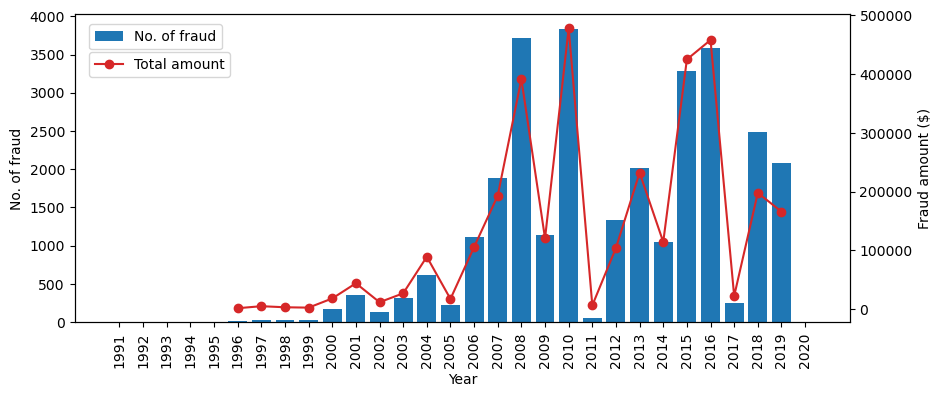

In [121]:
fig, ax = plt.subplots(figsize=(10, 4))

ax2 = ax.twinx()

x = data.groupby('year', as_index=True)['isFraud'].sum()
y = data.loc[data.isFraud == 1].groupby('year')['Amount'].sum()

ax.bar(x.index, x.values, label='No. of fraud')
ax2.plot(y.index, y.values, c='tab:red', marker='o', label='Total amount')
ax.set_xticks(x.index, x.index, rotation=90)
ax.set_xlabel('Year')
ax.set_ylabel('No. of fraud')
ax2.set_ylabel('Fraud amount ($)')
ax.legend(loc='upper left', bbox_to_anchor=(0.01, 0.99))
ax2.legend(loc='upper left', bbox_to_anchor=(0.01, 0.9))

plt.show()

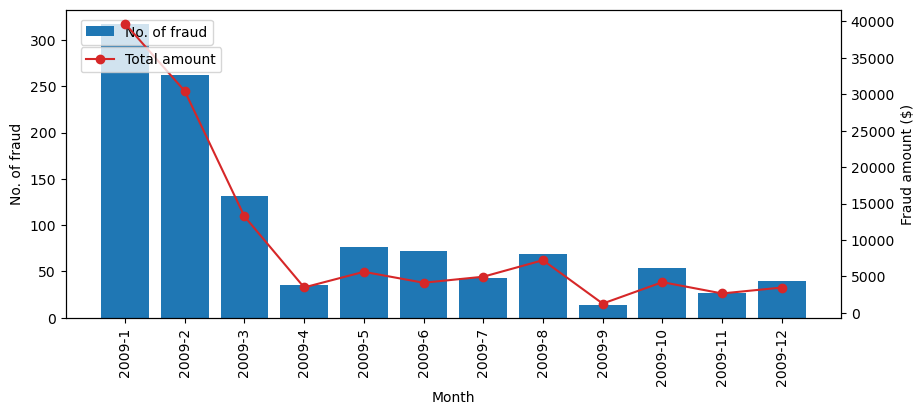

In [26]:
fig, ax = plt.subplots(figsize=(10, 4))

ax2 = ax.twinx()

x = data.groupby(['year', 'month'], as_index=True)['isFraud'].sum()
y = data.loc[data.isFraud == 1].groupby(['year', 'month'])['Amount'].sum()

ax.bar(x.index.map(lambda x: f'{x[0]}-{x[1]}'), x.values, label='No. of fraud')
ax2.plot(y.index.map(lambda x: f'{x[0]}-{x[1]}'), y.values, c='tab:red', marker='o', label='Total amount')
ax.set_xticks(x.index.map(lambda x: f'{x[0]}-{x[1]}'), x.index.map(lambda x: f'{x[0]}-{x[1]}'), rotation=90)
ax.set_xlabel('Month')
ax.set_ylabel('No. of fraud')
ax2.set_ylabel('Fraud amount ($)')
ax.legend(loc='upper left', bbox_to_anchor=(0.01, 0.99))
ax2.legend(loc='upper left', bbox_to_anchor=(0.01, 0.9))

plt.show()

# Define features

In [641]:
print('All variables:\n')
for i in df.columns.to_list():
    print(i if i != 'isFraud' else '')

All variables:

transactionTime
year
month
weekday
hour
User
Card
Amount
UseChip
MerchantName
MerchantCity
MerchantState
Zip
MCC
Error



In [7]:
# Rolling time window for user lever patterns
time_window='7D'

# --- Predictors

# Numerical variables
num_vars = ['Amount', 
            # 'userTxMean',
            # 'userTxMedian',
            # 'userTxStd',
            # 'userTxMax',
            # 'userTxMin',
            # 'userTxFreq',
            # 'userMerchant',
            # 'userMCC',
            # 'userCity',
            # 'userState',
            # 'userZip'
           ]
# Frequency encoding variables
freq_enc_vars = ['hour']# + ['MerchantName', 'MerchantCity',  'MerchantState', 'Zip', 'MCC'] + ['weekday', 'UseChip']
# Target encoding variables
target_enc_vars = ['MerchantName', 'MerchantCity',  'MerchantState', 'Zip', 'MCC', 'Error']
# One-hot encoding variables
onehot_enc_vars = ['weekday', 'UseChip']
# Categorical variables
cat_vars = freq_enc_vars+target_enc_vars+onehot_enc_vars
# List of all predictors
var_cols = num_vars+freq_enc_vars+target_enc_vars+onehot_enc_vars

# Logging configuration
# logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [650]:
Y=3
P1 = 479.99
P2 = 628.99

print(f'Forerunner P1 = {P1}')
print(f'Monthly over {Y} years: {P1/(12*Y):.2f}')
print(f'Discount: {100*(1-P1/599.99):.0f}%')
print()
print(f'Fenix P2 = {P2}')
print(f'Monthly over {Y} years: {P2/(12*Y):.2f}')
print(f'Discount: {100*(1-P2/739.99):.0f}%')
print()
print(f'Total price difference: {P2-P1}')
print(f'Total percentage increase: {100*(1-479.99/628.99):.0f}%')
print()
print(f'Monthly increase in {Y} years: {(P2-P1)/(12*Y):.2f}')
print(f'Percentage monthly increase in {Y} years: {100*(1-P1/P2)/(12*Y):.2f}%')


Forerunner P1 = 479.99
Monthly over 3 years: 13.33
Discount: 20%

Fenix P2 = 628.99
Monthly over 3 years: 17.47
Discount: 15%

Total price difference: 149.0
Total percentage increase: 24%

Monthly increase in 3 years: 4.14
Percentage monthly increase in 3 years: 0.66%


# Feature engineering

In [35]:
df.head()

,transactionTime,year,month,weekday,hour,User,Card,Amount,UseChip,MerchantName,MerchantCity,MerchantState,Zip,MCC,Error,isFraud,MerchantCityNum,MerchantStateNum
0,2008-01-01 00:00:00,2008,1,1,0,1911,4,19.23,0,5232322915998164853,Kissimmee,FL,34746.0,5813,NoError,0,0,0
1,2008-01-01 00:02:00,2008,1,1,0,583,2,97.29,0,3467663023930633227,Houston,TX,77047.0,5912,NoError,0,1,1
2,2008-01-01 00:05:00,2008,1,1,0,34,1,2.72,0,-4500542936415012428,Mobile,AL,36693.0,5814,NoError,0,2,2
3,2008-01-01 00:08:00,2008,1,1,0,928,2,160.00,0,-4282466774399734331,South Hill,VA,23970.0,4829,NoError,0,3,3
4,2008-01-01 00:08:00,2008,1,1,0,1497,2,140.00,0,-4282466774399734331,Crown Point,IN,46307.0,4829,NoError,0,4,4


In [31]:
# --- Feature engineering ---

def convert_to_numeric(df, feature):
    featureStr_to_featureNum = {iStr:iNum for iNum, iStr in enumerate(df[feature].unique())}
    return df[feature].map(featureStr_to_featureNum)
    
def feature_engineering(df):
    ''' Create new variables from data variables. '''

    # Convert 'MerchantCity' to numeric 'MerchantCityNum'
    df['MerchantCityNum'] = convert_to_numeric(df, 'MerchantCity')

    # Convert 'MerchantState' to numeric 'MerchantStateNum'
    df['MerchantStateNum'] = convert_to_numeric(df, 'MerchantState')

    # User level patterns
    dfnew = pd.DataFrame()
    for _ , gdata in df.groupby('User'):
        
        # Transaction patterns
        gdata['userTxMean'] = gdata.rolling(time_window, on='transactionTime')['Amount'].mean()
        gdata['userTxMedian'] = gdata.rolling(time_window, on='transactionTime')['Amount'].median()
        gdata['userTxStd'] = gdata.rolling(time_window, on='transactionTime')['Amount'].std().fillna(0)
        gdata['userTxMax'] = gdata.rolling(time_window, on='transactionTime')['Amount'].max()
        gdata['userTxMin'] = gdata.rolling(time_window, on='transactionTime')['Amount'].min()
        gdata['userTxFreq'] = gdata.rolling(time_window, on='transactionTime')['Amount'].count()
    
        # Merchant patterns
        gdata['userMerchant'] = gdata.rolling(time_window, on='transactionTime')['MerchantName'].apply(lambda x: x.nunique())
        gdata['userMCC'] = gdata.rolling(time_window, on='transactionTime')['MCC'].apply(lambda x: x.nunique())
    
        # Geographical patterns
        gdata['userCity'] = gdata.rolling(time_window, on='transactionTime')['MerchantCityNum'].apply(lambda x: x.nunique())
        gdata['userState'] = gdata.rolling(time_window, on='transactionTime')['MerchantStateNum'].apply(lambda x: x.nunique())
        gdata['userZip'] = gdata.rolling(time_window, on='transactionTime')['Zip'].apply(lambda x: x.nunique())
        
        dfnew = pd.concat([dfnew, gdata])
    df = dfnew.sort_values(by='transactionTime')

    return df


# Encoding/Scaling

In [116]:
# --- Encoding/Scaling ---
def onehot_transform(df, ohe_vars):
    ''' One-hot encoder. '''
    # Define one-hot encoder
    onehot_encoder = OneHotEncoder(sparse_output=False)
    
    # Fit-transform variables
    df_onehot = pd.DataFrame(onehot_encoder.fit_transform(df[ohe_vars].astype('str')))
    df_onehot.columns = onehot_encoder.get_feature_names_out()
    df_onehot.index = df.index
    
    # Remove original categorical variables
    df.drop(ohe_vars, axis=1, inplace=True)
    
    # Concatenate data set with one-hot columns
    df = pd.concat([df, df_onehot], axis=1)
    return df
def encode_scale_data(X_train, X_test, y_train, num_vars, target_enc_vars, freq_enc_vars, onehot_enc_vars):
    ''' Encode and scale data. '''
    pd.set_option('future.no_silent_downcasting', True)
    
    # Target encoding
    if target_enc_vars:
        target_encoder = TargetEncoder(cols=target_enc_vars)
        X_train = target_encoder.fit_transform(X_train, y_train)
        X_test = target_encoder.transform(X_test)
    
    # Frequency encoding
    if freq_enc_vars:
        freq_encoder = CountEncoder(cols=freq_enc_vars)
        X_train = freq_encoder.fit_transform(X_train, y_train)
        X_test = freq_encoder.transform(X_test)
    
    # Scaling
    if num_vars:
        scaler = StandardScaler(with_mean=True, with_std=True).set_output(transform="pandas")
        scale_cols = num_vars+freq_enc_vars+target_enc_vars
        scaler.fit(X_train[scale_cols])
        X_train = pd.concat([X_train.drop(scale_cols, axis=1), scaler.transform(X_train[scale_cols])], axis=1)
        X_test = pd.concat([X_test.drop(scale_cols, axis=1), scaler.transform(X_test[scale_cols])], axis=1)
    
    # One-hot encoding
    if onehot_enc_vars:
        X_train = onehot_transform(X_train, onehot_enc_vars)
        X_test = onehot_transform(X_test, onehot_enc_vars)

    return X_train, X_test

# Collinearity

In [47]:
# --- Collinearity ---
def remove_collinearity(X_train, X_test, num_vars, target_enc_vars, freq_enc_vars):
    ''' Remove high collinearity with VIF > 10. '''

    # Select columns
    vif_cols = num_vars+target_enc_vars+freq_enc_vars
    
    vif_removed_cols=[]
    while True:
        X_train_values = X_train[vif_cols].values
        
        # Variance Inflation Factor
        vif = pd.DataFrame()
        vif['Variable'] = vif_cols
        vif['VIF'] = [variance_inflation_factor(X_train_values, i) for i in range(X_train_values.shape[1])]
        vif = vif[vif.VIF > 10].sort_values(by='VIF', ascending=False)
        if vif.empty:
            break
    
        # Remove column with highest VIF (>10)
        vif_removed_cols.append(vif.iloc[0,0])
        X_train.drop(vif.iloc[0,0], axis=1, inplace=True)
        X_test.drop(vif.iloc[0,0], axis=1, inplace=True)
        vif_cols.remove(vif.iloc[0,0])
        logging.info(f'Remove column {vif.iloc[0,0]} with VIF = {vif.iloc[0,1]}')
        
    return X_train, X_test, vif_removed_cols

# Training model

In [10]:
def model_training(X_train_set, y_train_target, model):
    ''' Training the model.
        Models tested: Logistic Regression, Random Forest, LightLGB
    '''

    model.fit(X_train_set, y_train_target.values.ravel())

    return model

# Evaluate model

In [11]:
def evaluate_model(model, X_test, y_test):
    ''' Evaluate the model and return metrics obtained. '''
    
    # Model predictions
    pred = model.predict(X_test)
    # Prediction probabilities
    pred_prob = model.predict_proba(X_test)[:, 1]
    
    # Metrics
    metrics = {
        'confusion_matrix': confusion_matrix(y_test, pred),
        'classification_report': classification_report(y_test, pred),
        'recall_score': recall_score(y_test, pred),
        'precision_score': precision_score(y_test, pred),
        'f1_score': f1_score(y_test, pred),
        'precision_recall_curve': precision_recall_curve(y_test, pred_prob),
        'roc_auc_score': roc_auc_score(y_test, pred_prob),
        'roc_curve': roc_curve(y_test, pred_prob)
    }

    return metrics

In [12]:
# --- Precision recall curve ---
def plot_precision_recall_curve(model_pr_curve, color='C0', lw=2, marker=None, ax=None, 
                                title_fs=12, axis_label_fs=12, axis_tick_fs=12):
    ''' Plot the precision-recall curve.'''
    # Compute the precision, recall and threshold
    precision, recall, thresholds = model_pr_curve
    
    # fig, ax = plt.subplots(figsize=(4.5, 4))
    if ax is None:
        ax = plt.gca()
    
    # Plot the curve
    ax.plot([0, 1], [0, 1], color='k', linestyle='--', lw=1)  # Plot the diagonal line (random classifier)
    ax.plot(recall, precision, color=color, marker=marker, lw=lw)
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('Recall', fontsize=axis_label_fs)
    ax.set_ylabel('Precision', fontsize=axis_label_fs)
    ax.set_title('Precision-Recall Curve', fontsize=title_fs)
    ax.tick_params(labelsize=axis_tick_fs)
    ax.grid(True)

    plt.tight_layout()
    # plt.show()
    # plt.savefig('precision_recall_curve.png', dpi=500, bbox_inches='tight')

In [13]:
# Plot the ROC curve
def plot_roc_curve(model_roc_curve, model_roc_auc, color='C0', model_name=None, ax=None, 
                   lw=2, title_fs=12, axis_label_fs=12, legend_fs=10, axis_tick_fs=12):
    # Compute ROC curve and AUC
    fpr, tpr, thresholds = model_roc_curve
    roc_auc = model_roc_auc

    # fig, ax = plt.subplots(figsize=(4.5, 4))
    if ax is None:
        ax = plt.gca()

    ax.plot([0, 1], [0, 1], color='k', linestyle='--', lw=1)  # Plot the diagonal line (random classifier)
    ax.plot(fpr, tpr, color=color, lw=lw, label=f'{model_name} (AUC = {roc_auc:.2f})')
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate (FPR)', fontsize=axis_label_fs)
    ax.set_ylabel('True Positive Rate (TPR)', fontsize=axis_label_fs)
    ax.set_title('ROC Curve', fontsize=title_fs)
    ax.legend(loc='lower right', fontsize=legend_fs)
    ax.tick_params(labelsize=axis_tick_fs)
    ax.grid(True)
    # plt.show()


# main()

In [ ]:
# --- main() function --- 
# def main(transaction_file):

In [8]:
# # Data Folder
# data_folder = '/Users/efonesca.dos.reis/mrm_fraud/datasets/TabFormer/'
# # data_folder = '/data_clear/elohim/ccf/TabFormer/'
# # File
# file_name = 'card_transaction.v1.csv'

In [133]:
%%time
# Load data
df = pd.DataFrame()
for year in [2001]:
    df = pd.concat([df, load_data('card_transaction.v1-'+str(year)+'.csv', data_folder)])
# Convert variables
df.transactionTime = pd.to_datetime(df.transactionTime)
df.MerchantName = df.MerchantName.astype(str)
df.MCC = df.MCC.astype(str)
df.UseChip = df.UseChip.astype(str)
df.Zip = df.Zip.astype(int).astype(str)

CPU times: user 343 ms, sys: 46.1 ms, total: 389 ms
Wall time: 391 ms


In [15]:
%%time
# Preprocess data
# df = preprocess_data(df)

CPU times: user 6 μs, sys: 3 μs, total: 9 μs
Wall time: 15.3 μs


In [76]:
%%time
# Feature engineering
# df = feature_engineering(df)

CPU times: user 25.7 s, sys: 458 ms, total: 26.2 s
Wall time: 26.2 s


In [134]:
# Split data into Train/Test sets
X, y = df[var_cols], df['isFraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [16]:
def combine_geography(df, geo_vars=None):
    df = df.copy()
    var_name = '_'.join(geo_vars)
    df.insert(df.columns.get_loc(geo_vars[0]), var_name, df[geo_vars].agg('_'.join, axis=1))
    df.drop(geo_vars, axis=1, inplace=True)
    return df

In [62]:
def split_geography(df, geo_vars=None):
    var_name = '_'.join(geo_vars)
    idx = df.columns.get_loc(var_name)
    df_split = df[var_name].str.split('_', expand=True)
    df_split.columns = geo_vars
    return pd.concat([df.iloc[:, :idx], df_split, df.iloc[:, idx:]], axis=1).drop(var_name, axis=1)

# STOPPED HERE

In [135]:
# Class imbalance

# Geographical features
geo_vars = ['MerchantName', 'Zip', 'MerchantCity', 'MerchantState']

# Undersample
# Combine geographical features
# SMOTENC
# Split geographical features

In [18]:
def aux(X, variables=None, p=False):
    for var in variables:
        print(var, X[var].nunique())
        if p:
            print(X[var].unique())

In [66]:
print('Before\n')
print(f'Size of train set: {len(X_train)}\n')
aux(X_train, variables=X_train.columns.to_list())


Before

Size of train set: 206398

Amount 21854
hour 24
MerchantName 7516
MerchantCity 3267
MerchantState 85
Zip 5576
MCC 109
Error 16
weekday 7
UseChip 2


In [78]:
print('After\n')
print(f'Size of train set: {len(X_train)}\n')
aux(X_train, variables=X_train.columns.to_list())


After

Size of train set: 202000

Amount 118118
hour 24
MerchantName 5882
Zip 4640
MerchantCity 2764
MerchantState 84
MCC 108
Error 13
weekday 7
UseChip 2


In [100]:
# Class imbalance
def class_imbalance(X_train, y_train, under_sample=True, undersample_ratio=0.005, geo_vars=None, cat_vars=None):
    
    # Undersample
    if under_sample:
        # Random Under Sampler
        undersampler = RandomUnderSampler(sampling_strategy=under_sample_ratio)
        X_train, y_train = undersampler.fit_resample(X_train, y_train)

    # Combine geographical features
    X_train = combine_geography(X_train, geo_vars=geo_vars)

    # SMOTENC
    categorical_features = [v for v in cat_vars if v not in geo_vars]+['_'.join(geo_vars)]
    smotenc = SMOTENC(categorical_features=categorical_features, random_state=1)
    X_train, y_train = smotenc.fit_resample(X_train, y_train)

    # Split geographical features
    X_train = split_geography(X_train, geo_vars=geo_vars)

    return X_train, y_train

In [136]:
%%time
# Class imbalance
X_train, y_train = class_imbalance(X_train, y_train, 
                                   undersample_ratio=0.0031, 
                                   geo_vars=['MerchantName', 'MerchantCity', 'MerchantState', 'Zip'],
                                   cat_vars=cat_vars
                                  )

CPU times: user 1min, sys: 25.5 s, total: 1min 25s
Wall time: 1min 42s


In [137]:
%%time
# Encode and scale data
X_train, X_test = encode_scale_data(X_train, X_test, y_train, num_vars, target_enc_vars, freq_enc_vars, onehot_enc_vars)

CPU times: user 920 ms, sys: 52.6 ms, total: 973 ms
Wall time: 972 ms


In [391]:
# %%time
# # Remove collinearity with VIF
# X_train, X_test, vif_removed_cols = remove_collinearity(X_train, X_test, num_vars, target_enc_vars, freq_enc_vars)
# logging.info(f'Removed columns due to collinearity: {vif_removed_cols}')

In [585]:
# # Class imbalance: oversample with SMOTE to treat class imbalance
# smote = SMOTE(sampling_strategy='auto', random_state=1)
# X_train, y_train = smote.fit_resample(X_train, y_train)

In [259]:
# Train model

In [138]:
model_dict={}
model_dict['lr'] = LogisticRegression(class_weight='balanced', max_iter=500, random_state=1)
# model_dict['rf'] = RandomForestClassifier(n_jobs=5, 
#                                       random_state=1,
#                                       criterion='log_loss',
#                                       class_weight='balanced',
#                                       verbose=False)
model_dict['lgbm'] = LGBMClassifier(objective='binary', is_unbalance=True, random_state=1)
model_dict['mlp'] = MLPClassifier(random_state=1)

model_name={'lr':'LR', 'lgbm':'LightGBM', 'mlp':'MLP'}

In [139]:
%%time
model=dict()
metrics=dict()
for m in model_dict:
    print(m)
    model[m] = model_training(X_train, y_train, model_dict[m])
    metrics[m] = evaluate_model(model[m], X_test, y_test)
    print('ok')

lr
ok
lgbm
[LightGBM] [Info] Number of positive: 101000, number of negative: 101000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.053774 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 847
[LightGBM] [Info] Number of data points in the train set: 202000, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
ok
mlp
ok
CPU times: user 2min 46s, sys: 8.14 s, total: 2min 55s
Wall time: 18 s


In [395]:
# --- MISSING ---
    # # Cross-validation
    # cross_validation(model, X_train, y_train)

In [ ]:

    # # Compute probabilites for all data transactions
    # df_all_pred_prob = all_transactions_pred_prob(model, X, y, df, vif_removed_cols, num_vars, target_enc_vars, freq_enc_vars, onehot_enc_vars)

    # # Plot figures
    # plot_feature_importance(model)
    # plot_precision_recall_curve(y_test, pred_prob)
    # plot_review_load(df_all_pred_prob, y_test, pred_prob)

    # return model, metrics

# Model performance

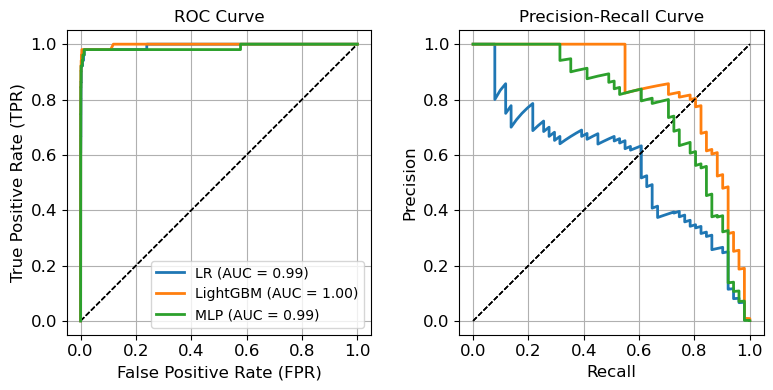

In [140]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))


for i, m in enumerate(model_dict.keys()):
    # ROC curve
    plot_roc_curve(metrics[m]['roc_curve'], metrics[m]['roc_auc_score'], model_name=model_name[m], color='C'+str(i), ax=ax[0])
    # PR curve
    plot_precision_recall_curve(metrics[m]['precision_recall_curve'], color='C'+str(i), ax=ax[1])

ax[0].set_aspect('equal')
ax[1].set_aspect('equal')

# plt.savefig(fig_folder+'roc_pr_curve.png', dpi=300)
plt.show()

In [141]:
models_metrics=[]
for m in model_dict:
    models_metrics.append([metrics[m]['precision_score'], 
                           metrics[m]['recall_score'], 
                           metrics[m]['f1_score'], 
                           metrics[m]['roc_auc_score']])

pd.DataFrame(models_metrics, columns=['Precision', 'Recall', 'F1', 'ROC-AUC'], index=['LR', 'LGBM', 'MLP']).round(2).T

,LR,LGBM,MLP
Precision,0.13,0.60,0.41
Recall,0.92,0.86,0.86
F1,0.22,0.71,0.55
ROC-AUC,0.99,1.00,0.99


In [142]:
print(pd.DataFrame(models_metrics, columns=['Precision', 'Recall', 'F1', 'ROC-AUC'], index=['LR', 'LGBM', 'MLP']).round(2).T.to_latex())

\begin{tabular}{lrrr}
\toprule
 & LR & LGBM & MLP \\
\midrule
Precision & 0.130000 & 0.600000 & 0.410000 \\
Recall & 0.920000 & 0.860000 & 0.860000 \\
F1 & 0.220000 & 0.710000 & 0.550000 \\
ROC-AUC & 0.990000 & 1.000000 & 0.990000 \\
\bottomrule
\end{tabular}



# Explainability

## SHAP

In [143]:
%%time
shap_values={}
explainer={}
for m in model_dict.keys():
    print(m)
    
    if m == 'mlp':
        pass
        # # Create SHAP Explainer for model
        # X_train_kmeans = shap.kmeans(X_train, 100) # Summarize train set with k mean samples
        # explainer = shap.KernelExplainer(model[m].predict, X_train_kmeans)
        # # Calculate SHAP values
        # shap_values[m] = explainer(X_test)
    else:
        # Create SHAP Explainer for model
        explainer[m] = shap.Explainer(model[m], X_train)
        # Calculate SHAP values
        shap_values[m] = explainer[m](X_test)
        
    print('ok')

lr
ok
lgbm


 99%|===================| 51338/51600 [00:57<00:00]        

ok
mlp
ok
CPU times: user 57.8 s, sys: 109 ms, total: 57.9 s
Wall time: 57.9 s


In [170]:
lr_featImportance = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficients': model['lr'].coef_[0]
}).sort_values(by='Coefficients', ascending=True)

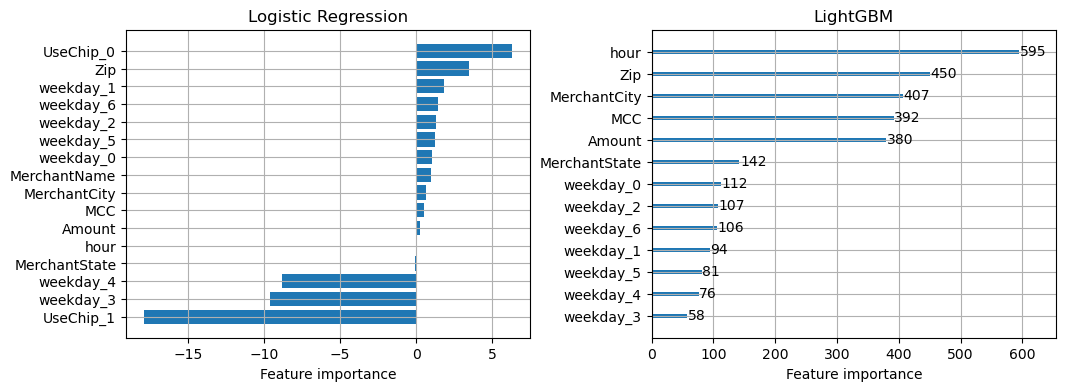

In [171]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].barh(lr_featImportance.Feature, lr_featImportance.Coefficients)
ax[0].set_title('Logistic Regression')
ax[0].set_xlabel('Feature importance')
ax[0].grid()

lgb.plot_importance(model_dict['lgbm'], importance_type='auto', ax=ax[1])
ax[1].set_ylabel('')
ax[1].set_title('LightGBM')

plt.subplots_adjust(wspace=0.3)

lr
lgbm


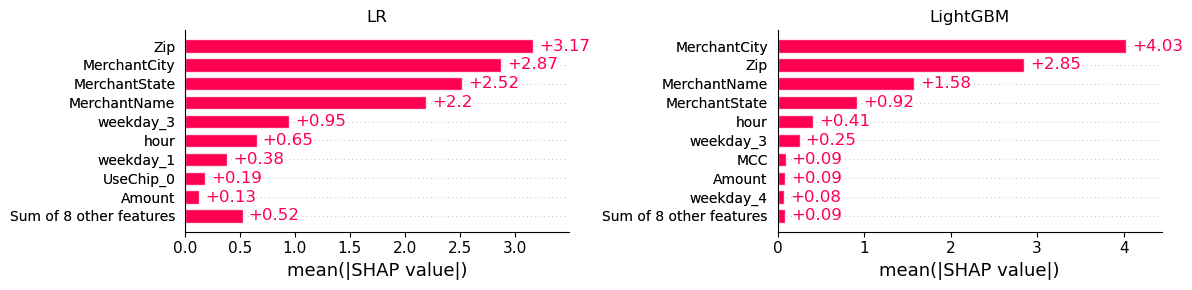

In [144]:
fig, ax = plt.subplots(1, 2, figsize=(12, 3))

# plt.figure()
for i, m in enumerate(model_dict.keys()):
    if m == 'mlp':
        pass
    else:
        print(m)
        # plt.subplot(1, 2, i+1)
        shap.plots.bar(shap_values[m], ax=ax[i], show=False)
        # plt.xlabel_format(fontsize=10)
        ax[i].set_title(model_name[m])
        ax[i].tick_params(axis='y', which='major', labelsize=10)
plt.tight_layout()
plt.show()

lr
lgbm


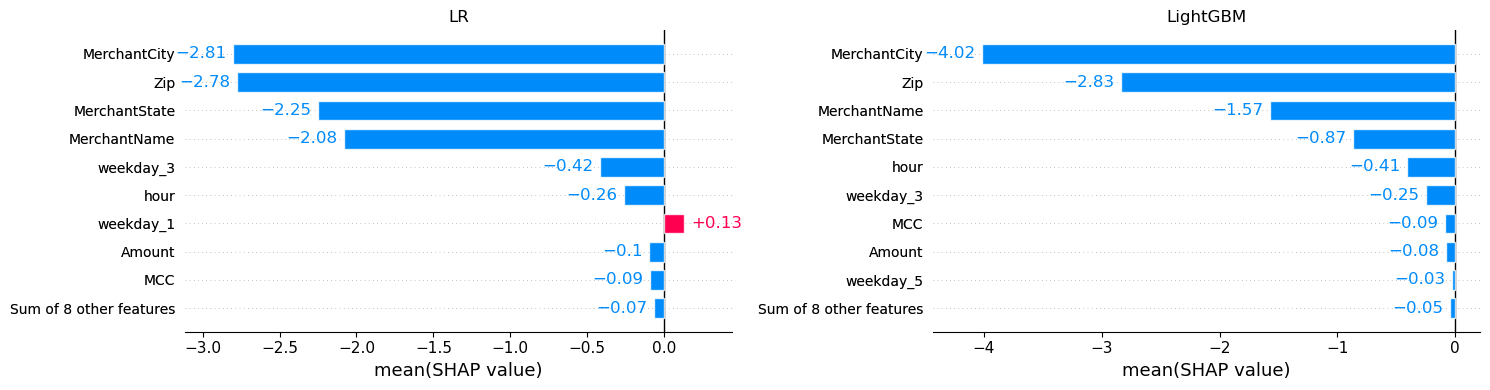

In [145]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))


# plt.figure()
for i, m in enumerate(model_dict.keys()):
    if m == 'mlp':
        pass
    else:
        print(m)
        # plt.subplot(1, 2, i+1)
        # shap.plots.bar(shap_values[m].min(0), ax=ax[i], show=False)
        # shap.plots.bar(shap_values[m].max(0), ax=ax[i], show=False)
        # shap.plots.bar(shap_values[m].abs.mean(0), ax=ax[i], show=False)
        shap.plots.bar(shap_values[m].mean(0), ax=ax[i], show=False)
        # plt.xlabel_format(fontsize=10)
        ax[i].set_title(model_name[m])
        ax[i].tick_params(axis='y', which='major', labelsize=10)
plt.tight_layout()
plt.show()

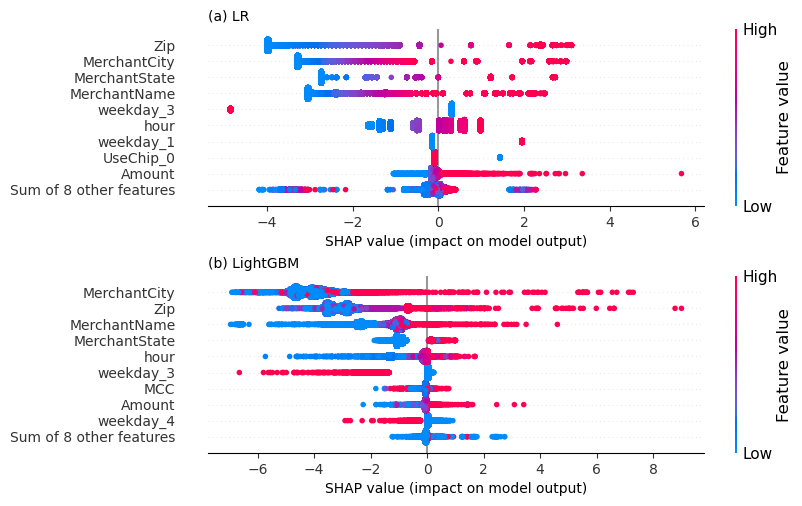

In [146]:
plt.figure(figsize=(12, 10))

title={0:'(a) ', 1:'(b) '}
for i, m in enumerate(['lr', 'lgbm']):
    plt.subplot(2, 1, i+1)
    shap.plots.beeswarm(shap_values[m], show=False)
    plt.title(title[i]+model_name[m], loc='left', fontsize=10)
    plt.tick_params(axis='both', labelsize=10)
    plt.gca().xaxis.label.set_size(10)
plt.subplots_adjust(hspace=0.4)
plt.savefig(fig_folder+'shap_values.png', dpi=300, bbox_inches='tight')
plt.show()

## Permutation Importance

In [147]:
def get_perm_imp(X, y, model_dict, scoring=None, n_reps=30, n_samples=1.0, random_state=1):
    perm_imp={}
    for m in model_dict:
        perm_imp[m] = permutation_importance(model_dict[m], X, y, 
                                             scoring=scoring,
                                             n_repeats=n_reps, 
                                             max_samples=n_samples, 
                                             random_state=random_state)
    return perm_imp

In [148]:
def plot_perm_imp(perm_imp, ax=None, model_name=None):

    sorted_importances_idx = perm_imp.importances_mean.argsort()
    importances = pd.DataFrame(
        perm_imp.importances[sorted_importances_idx].T,
        columns=X_test.columns[sorted_importances_idx],
    )
    importances.plot.box(vert=False, whis=10, ax=ax)
    ax.axvline(x=0, color="k", linestyle="--")

In [149]:
%%time
perm_imp = get_perm_imp(X_test, y_test, model_dict, scoring=['recall', 'precision'], 
                        n_reps=30, 
                        n_samples=1.0
                       )

CPU times: user 4min 26s, sys: 2min 42s, total: 7min 8s
Wall time: 46.4 s


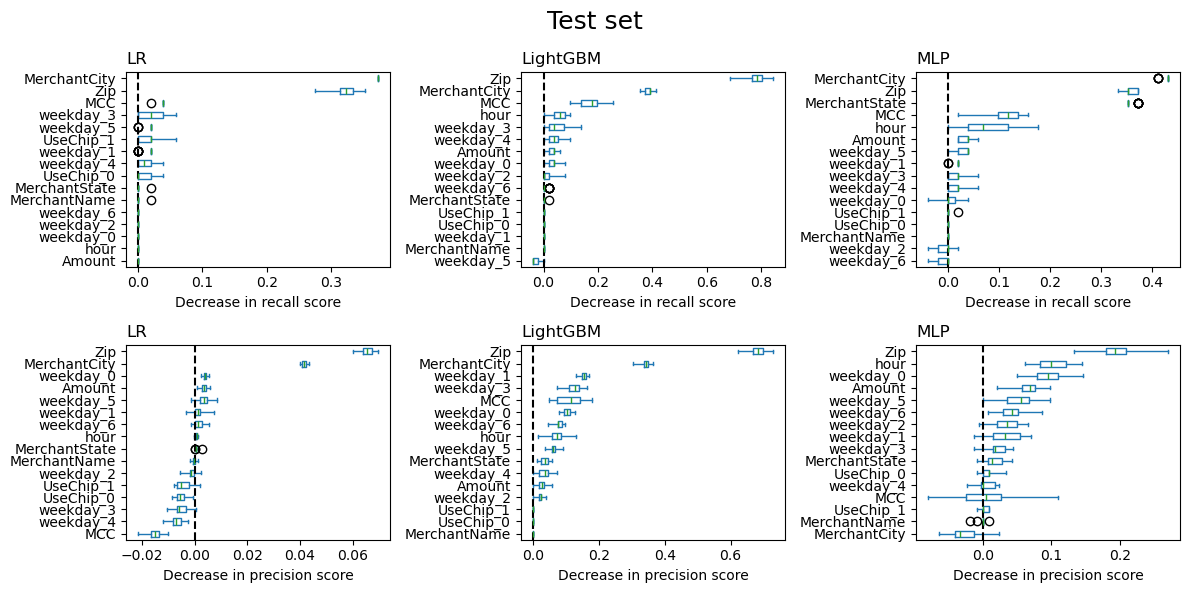

In [399]:
fig, ax = plt.subplots(len(scoring), len(perm_imp.keys()), figsize=(12, 6))

for j, m in enumerate(['lr', 'lgbm', 'mlp']):
    for i, metric in enumerate(scoring):
        plot_perm_imp(perm_imp[m][metric], model_name=model_name[m], ax=ax[i, j])
        ax[i,j].set_title(model_name[m], loc='left')
        ax[i,j].set_xlabel('Decrease in '+metric+' score')
        # ax[i,j].figure.tight_layout()
fig.suptitle('Test set', y=0.98, fontsize=18)
plt.tight_layout()
plt.savefig(fig_folder+'permutation_importance_test.png', dpi=300, bbox_inches='tight')
plt.show()

KeyError: 'lr'

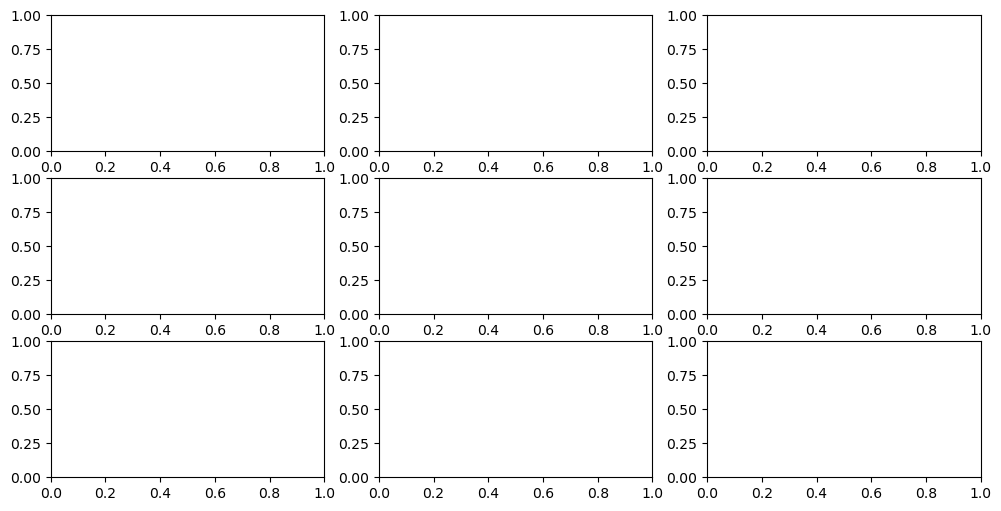

In [152]:
scoring=['lr', 'lgbm', 'mlp']
fig, ax = plt.subplots(len(scoring), len(perm_imp.keys()), figsize=(12, 6))

for j, m in enumerate(['lr', 'lgbm', 'mlp']):
    for i, metric in enumerate(scoring):
        plot_perm_imp(perm_imp[m][metric], model_name=model_name[m], ax=ax[i, j])
        ax[i,j].set_title(model_name[m], loc='left')
        ax[i,j].set_xlabel('Decrease in '+metric+' score')
        # ax[i,j].figure.tight_layout()
fig.suptitle('Test set', y=0.98, fontsize=18)
plt.tight_layout()
plt.savefig(fig_folder+'permutation_importance_test.png', dpi=300, bbox_inches='tight')
plt.show()

In [440]:
m = 'lr'
s = 'recall'
for s in scoring:
    peImp = perm_imp[m][s]
    table_perm_imp=[]
    for i in peImp.importances_mean.argsort()[::-1][:3]:
        table_perm_imp.append([X_test.columns[i], str(peImp.importances_mean[i].round(3))+' +/- '+str(peImp.importances_std[i].round(3))])
    display(pd.DataFrame(table_perm_imp).set_index(0).rename_axis(None).rename(columns={1:s}))

,recall
MerchantCity,0.373 +/- 0.0
Zip,0.322 +/- 0.021
MCC,0.039 +/- 0.004


,precision
Zip,0.065 +/- 0.002
MerchantCity,0.042 +/- 0.001
weekday_0,0.004 +/- 0.001


In [420]:
for i in permimp.importances_mean.argsort()[::-1]:
    # if permimp.importances_mean[i] - 2 * permimp.importances_std[i] > 0:
    print(f"{X_test.columns[i]:<8}"
          f"\t{permimp.importances_mean[i]:.3f}"
          f" +/- {permimp.importances_std[i]:.3f}")

Zip     	0.767 +/- 0.031
MerchantCity	0.382 +/- 0.018
MCC     	0.159 +/- 0.045
hour    	0.049 +/- 0.024
weekday_3	0.045 +/- 0.038
weekday_4	0.033 +/- 0.018
Amount  	0.029 +/- 0.010
weekday_0	0.020 +/- 0.018
MerchantState	0.018 +/- 0.006
weekday_6	0.014 +/- 0.018
weekday_2	0.010 +/- 0.013
weekday_1	0.002 +/- 0.006
UseChip_1	0.000 +/- 0.000
UseChip_0	0.000 +/- 0.000
MerchantName	0.000 +/- 0.000
weekday_5	-0.037 +/- 0.006


## PDP

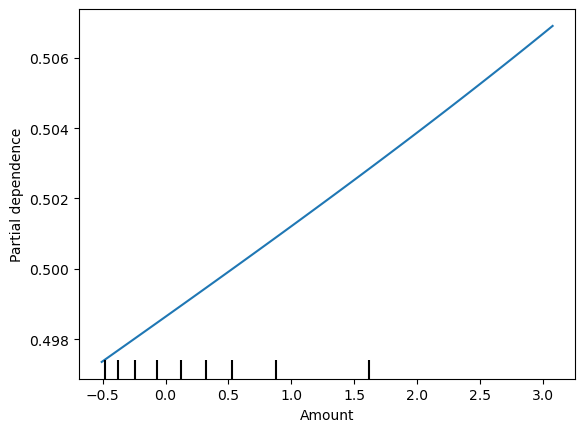

In [542]:
m='lr'
features_pdp ={
    'features': ['Amount'],
    # 'categorical_features':['MCC']
} 

PartialDependenceDisplay.from_estimator(model_dict[m], X_train, **features_pdp)

## Surrogate model

## LIME

# Robustness

# main()

In [298]:
%%time

def eval_robustness_perform(years=None, models=None):
    metrics = {m:[] for m in models}
    # Data shift - model performance
    for year in years:
        print(year)
        df = load_data('card_transaction.v1-'+str(year)+'.csv', data_folder)
        # Convert transaction time to datetime
        df.transactionTime = pd.to_datetime(df.transactionTime)
    
        # Split data into Train/Test sets
        X, y = df[var_cols], df['isFraud']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    
        # Encode and scale data
        X_train, X_test = encode_scale_data(X_train, X_test, y_train, num_vars, target_enc_vars, freq_enc_vars, onehot_enc_vars)
    
        # Class imbalance: oversample with SMOTE to treat class imbalance
        smote = SMOTE(sampling_strategy='auto', random_state=1)
        X_train, y_train = smote.fit_resample(X_train, y_train)
    
        # Train and evaluate models
        # model=dict()
        for m in models:#model_dict:
            print(m)
            # Train
            model = model_training(X_train, y_train, model_dict[m])
            # # Evaluate
            # robustness_metrics[m][year] = evaluate_model(model, X_test, y_test)
    
            # Model predictions
            pred = model.predict(X_test)
            
            # Metrics
            metrics[m].append([year, 
                               recall_score(y_test, pred), 
                               precision_score(y_test, pred),
                               f1_score(y_test, pred)
                              ])
            
            print('ok')
        print('year ok\n')
    
    for m in models:
        df = pd.DataFrame(metrics[m], columns=['year', 'recall', 'precision', 'f1'])
        df['year'] = df['year'].astype(str)
        metrics[m] = df
    
    return metrics
    

CPU times: user 5 μs, sys: 2 μs, total: 7 μs
Wall time: 10.7 μs


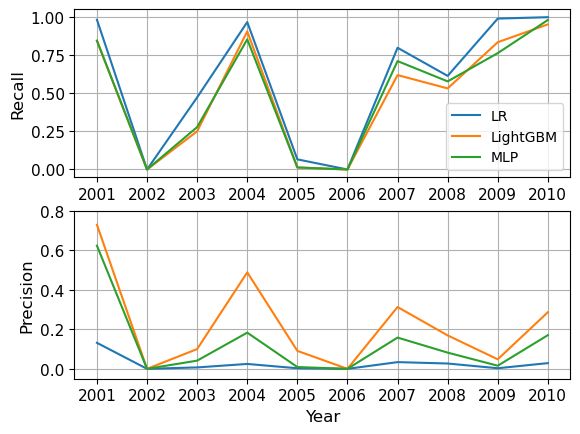

In [351]:
axis_label_fs = 12
axis_tick_fs = 11
legend_fs = 10

fig, ax = plt.subplots(2, 1)
for m in models:
    y = robust_perfm[m].year
    rec = robust_perfm[m].recall
    prec = robust_perfm[m].precision

    # Recall
    ax[0].plot(y, rec, label=model_name[m])

    # Precision
    ax[1].plot(y, prec)

ax[0].legend(fontsize=legend_fs)
ax[0].set_ylim(bottom=-0.05, top=1.05)
ax[0].set_ylabel('Recall', fontsize=axis_label_fs)
ax[0].tick_params(labelsize=axis_tick_fs)
ax[0].grid()

ax[1].set_ylim(top=0.8, bottom=-0.05)
ax[1].set_ylabel('Precision', fontsize=axis_label_fs)
ax[1].set_xlabel('Year', fontsize=axis_label_fs)
ax[1].tick_params(labelsize=axis_tick_fs)
ax[1].grid()

plt.show()

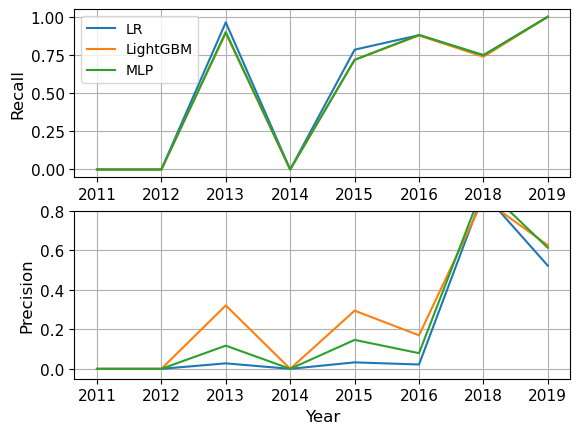

In [352]:
axis_label_fs = 12
axis_tick_fs = 11
legend_fs = 10

fig, ax = plt.subplots(2, 1)
for m in models:
    y = robust_perfm2[m].year
    rec = robust_perfm2[m].recall
    prec = robust_perfm2[m].precision

    # Recall
    ax[0].plot(y, rec, label=model_name[m])

    # Precision
    ax[1].plot(y, prec)

ax[0].legend(fontsize=legend_fs)
ax[0].set_ylim(bottom=-0.05, top=1.05)
ax[0].set_ylabel('Recall', fontsize=axis_label_fs)
ax[0].tick_params(labelsize=axis_tick_fs)
ax[0].grid()

ax[1].set_ylim(top=0.8, bottom=-0.05)
ax[1].set_ylabel('Precision', fontsize=axis_label_fs)
ax[1].set_xlabel('Year', fontsize=axis_label_fs)
ax[1].tick_params(labelsize=axis_tick_fs)
ax[1].grid()

plt.show()

In [354]:
robust_perfm['lr']

,year,recall,precision
0,2001,0.980392,0.131579
1,2002,0.000000,0.000000
2,2003,0.472222,0.007234
3,2004,0.965217,0.024777
4,2005,0.066225,0.002987
5,2006,0.000000,0.000000
6,2007,0.796992,0.034007
7,2008,0.612795,0.026948
8,2009,0.988095,0.003066
9,2010,0.997147,0.028927


In [355]:
robust_perfm2['lr']

,year,recall,precision
0,2011,0.000000,0.000000
1,2012,0.000000,0.000000
2,2013,0.963415,0.027766
3,2014,0.000000,0.000000
4,2015,0.784383,0.032764
5,2016,0.879371,0.021975
6,2018,0.748333,0.889109
7,2019,1.000000,0.521739


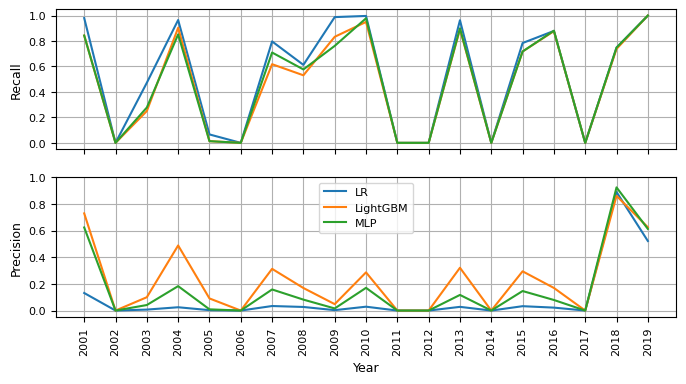

In [376]:
axis_label_fs = 9
axis_tick_fs = 8
legend_fs = 8
title_fs = 9

fig, ax = plt.subplots(2, 1, figsize=(8, 4))
for m in models:
    df = pd.concat([robust_perfm[m], robust_perfm2[m]])
    df = pd.concat([df, pd.DataFrame([['2017', 0, 0]], columns=df.columns)]).sort_values(by='year')
    y = df.year
    rec = df.recall
    prec = df.precision

    # Recall
    ax[0].plot(y, rec, label=model_name[m])

    # Precision
    ax[1].plot(y, prec, label=model_name[m])

# Formatting

ax[0].set_ylim(bottom=-0.05, top=1.05)
ax[0].set_ylabel('Recall', fontsize=axis_label_fs)
ax[0].tick_params(labelsize=axis_tick_fs)
ax[0].grid()

ax[1].set_ylim(top=1, bottom=-0.05)
ax[1].set_ylabel('Precision', fontsize=axis_label_fs)
ax[1].set_xlabel('Year', fontsize=axis_label_fs)
ax[1].tick_params(labelsize=axis_tick_fs)
ax[1].grid()
ax[1].legend(fontsize=legend_fs)

ax[0].set_xticks(df.year, ['' for i in df.year])
ax[1].set_xticks(df.year, df.year, rotation=90)

plt.savefig(fig_folder+'performance_robustness.png', dpi=300, bbox_inches='tight')
plt.show()

In [306]:
%%time
years = [2001+i for i in range(10)]
models = ['lr', 'lgbm', 'mlp']
metrics = []
robust_perfm = eval_robustness_perform(years=years, models=models)

2001
lr
ok
lgbm
[LightGBM] [Info] Number of positive: 206095, number of negative: 206095
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033412 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3069
[LightGBM] [Info] Number of data points in the train set: 412190, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
ok
mlp
ok
year ok

2002
lr
ok
lgbm
[LightGBM] [Info] Number of positive: 280566, number of negative: 280566
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040050 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2340
[LightGBM] [Info] Number of data points in the train set: 561132, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/Users/efonesca.dos.reis/miniconda3/envs/mrm/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ok
mlp


/Users/efonesca.dos.reis/miniconda3/envs/mrm/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ok
year ok

2003
lr
ok
lgbm
[LightGBM] [Info] Number of positive: 372851, number of negative: 372851
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012824 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3638
[LightGBM] [Info] Number of data points in the train set: 745702, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
ok
mlp
ok
year ok

2004
lr
ok
lgbm
[LightGBM] [Info] Number of positive: 477097, number of negative: 477097
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013948 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2809
[LightGBM] [Info] Number of data points in the train set: 954194, number of used features: 16
[Lig

/Users/efonesca.dos.reis/miniconda3/envs/mrm/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ok
lgbm
[LightGBM] [Info] Number of positive: 725916, number of negative: 725916
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022325 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3345
[LightGBM] [Info] Number of data points in the train set: 1451832, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/Users/efonesca.dos.reis/miniconda3/envs/mrm/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ok
mlp


/Users/efonesca.dos.reis/miniconda3/envs/mrm/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ok
year ok

2007
lr
ok
lgbm
[LightGBM] [Info] Number of positive: 850370, number of negative: 850370
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029816 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3884
[LightGBM] [Info] Number of data points in the train set: 1700740, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
ok
mlp
ok
year ok

2008
lr
ok
lgbm
[LightGBM] [Info] Number of positive: 975949, number of negative: 975949
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.046512 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3485
[LightGBM] [Info] Number of data points in the train set: 1951898, number of used features: 16
[L

In [307]:
robust_perfm['lr']

,year,recall,precision
0,2001,0.980392,0.131579
1,2002,0.000000,0.000000
2,2003,0.472222,0.007234
3,2004,0.965217,0.024777
4,2005,0.066225,0.002987
5,2006,0.000000,0.000000
6,2007,0.796992,0.034007
7,2008,0.612795,0.026948
8,2009,0.988095,0.003066
9,2010,0.997147,0.028927


In [336]:
[2011+i for i in range(9) if i != 6]

[2011, 2012, 2013, 2014, 2015, 2016, 2018, 2019]

In [339]:
%%time
years = [2011+i for i in range(9) if i != 6] # do not include 2017, no fraud cases
models = ['lr', 'lgbm', 'mlp']
metrics = []
robust_perfm2 = eval_robustness_perform(years=years, models=models)

2011
lr


/Users/efonesca.dos.reis/miniconda3/envs/mrm/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ok
lgbm
[LightGBM] [Info] Number of positive: 1256385, number of negative: 1256385
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044926 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3179
[LightGBM] [Info] Number of data points in the train set: 2512770, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/Users/efonesca.dos.reis/miniconda3/envs/mrm/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ok
mlp


/Users/efonesca.dos.reis/miniconda3/envs/mrm/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ok
year ok

2012
lr


/Users/efonesca.dos.reis/miniconda3/envs/mrm/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ok
lgbm
[LightGBM] [Info] Number of positive: 1287330, number of negative: 1287330
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039352 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4045
[LightGBM] [Info] Number of data points in the train set: 2574660, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/Users/efonesca.dos.reis/miniconda3/envs/mrm/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ok
mlp


/Users/efonesca.dos.reis/miniconda3/envs/mrm/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ok
year ok

2013
lr
ok
lgbm
[LightGBM] [Info] Number of positive: 1319453, number of negative: 1319453
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043115 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 2638906, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
ok
mlp
ok
year ok

2014
lr


/Users/efonesca.dos.reis/miniconda3/envs/mrm/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ok
lgbm
[LightGBM] [Info] Number of positive: 1336822, number of negative: 1336822
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038724 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4078
[LightGBM] [Info] Number of data points in the train set: 2673644, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/Users/efonesca.dos.reis/miniconda3/envs/mrm/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ok
mlp


/Users/efonesca.dos.reis/miniconda3/envs/mrm/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ok
year ok

2015
lr
ok
lgbm
[LightGBM] [Info] Number of positive: 1358942, number of negative: 1358942
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037959 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3905
[LightGBM] [Info] Number of data points in the train set: 2717884, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
ok
mlp
ok
year ok

2016
lr
ok
lgbm
[LightGBM] [Info] Number of positive: 1364132, number of negative: 1364132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.059723 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4121
[LightGBM] [Info] Number of data points in the train set: 2728264, number of used features: 1

In [340]:
robust_perfm2['lr']

,year,recall,precision
0,2011,0.000000,0.000000
1,2012,0.000000,0.000000
2,2013,0.963415,0.027766
3,2014,0.000000,0.000000
4,2015,0.784383,0.032764
5,2016,0.879371,0.021975
6,2018,0.748333,0.889109
7,2019,1.000000,0.521739


In [ ]:
def evaluate_model2(model, X_test, y_test):
    ''' Evaluate the model and return metrics obtained for data shift robustness. '''
    
    # Model predictions
    pred = model.predict(X_test)
    
    # Metrics
    metrics = {
        'recall_score': recall_score(y_test, pred),
        'precision_score': precision_score(y_test, pred)
    }

    return metrics

In [ ]:
()